# Libraries

In [105]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, concatenate, Convolution2D, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging

# Data loading and exploration

In [18]:
IMG_SHAPE  = 227
batch_size = 32
random_seed = 9

In [19]:
fpath = './Dataset_RemovedBG'
categories = os.listdir(fpath)
categories.pop(1)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['totally_green', 'yellow_with_brown_spots', 'yellow_with_green_tips'] 

No. of categories =  3


In [20]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  288 
No. of labels loaded =  288
<class 'list'> <class 'list'>


In [21]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (288, 227, 227, 3) 
Labels shape =  (288,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


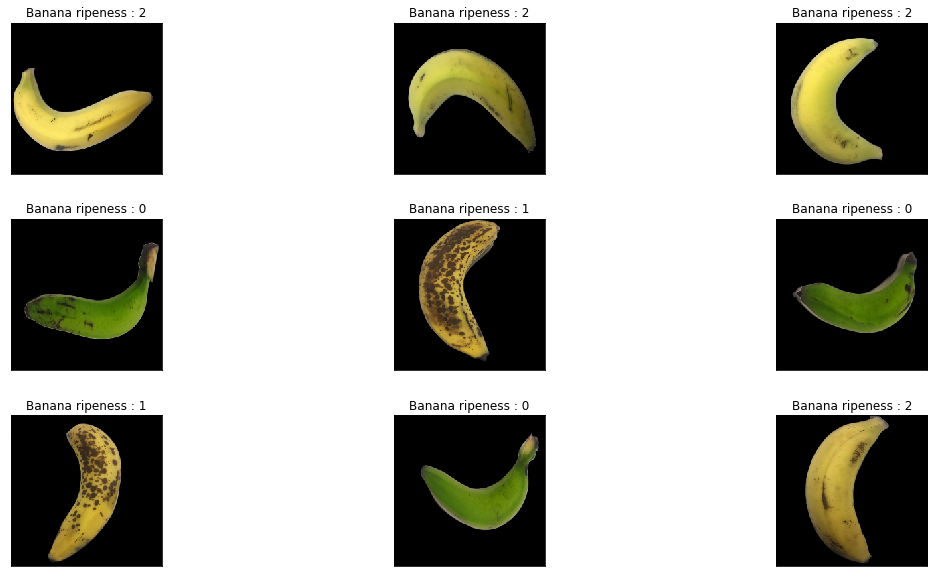

In [22]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Banana ripeness : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [23]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

In [24]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (288, 227, 227, 3) 
Labels shape after shuffling =  (288,)


In [25]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (288, 227, 227, 3)


In [26]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (172, 227, 227, 3)
y_train shape =  (172,)

x_test shape =  (58, 227, 227, 3)
y_test shape =  (58,)

x_val shape =  (58, 227, 227, 3)
y_val shape =  (58,)


In [27]:
##One-hot-encode
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_val = to_categorical(y_val, 3)

# Define CNN model

In [86]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [106]:
pre_trained_model = SqueezeNet(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

3039232/3032184 [==============================] - 1s 0us/step


In [107]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_14
conv1
relu_conv1
pool1
fire2/squeeze1x1
fire2/relu_squeeze1x1
fire2/expand1x1
fire2/expand3x3
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/concat
fire3/squeeze1x1
fire3/relu_squeeze1x1
fire3/expand1x1
fire3/expand3x3
fire3/relu_expand1x1
fire3/relu_expand3x3
fire3/concat
pool3
fire4/squeeze1x1
fire4/relu_squeeze1x1
fire4/expand1x1
fire4/expand3x3
fire4/relu_expand1x1
fire4/relu_expand3x3
fire4/concat
fire5/squeeze1x1
fire5/relu_squeeze1x1
fire5/expand1x1
fire5/expand3x3
fire5/relu_expand1x1
fire5/relu_expand3x3
fire5/concat
pool5
fire6/squeeze1x1
fire6/relu_squeeze1x1
fire6/expand1x1
fire6/expand3x3
fire6/relu_expand1x1
fire6/relu_expand3x3
fire6/concat
fire7/squeeze1x1
fire7/relu_squeeze1x1
fire7/expand1x1
fire7/expand3x3
fire7/relu_expand1x1
fire7/relu_expand3x3
fire7/concat
fire8/squeeze1x1
fire8/relu_squeeze1x1
fire8/expand1x1
fire8/expand3x3
fire8/relu_expand1x1
fire8/relu_expand3x3
fire8/concat
fire9/squeeze1x1
fire9/relu_squeeze1x1
fire9/expand1x1
fire9/expand3x3
fir

In [108]:
last_layer = pre_trained_model.get_layer('fire9/concat')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)

# Train model

In [109]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [110]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           relu_conv1[0][0]                 
_______________________________________________________________________________________

In [111]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [112]:
x_train.shape,y_train.shape

((172, 227, 227, 3), (172, 3))

In [123]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_SqueezeNet_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
5/5 [==============================] - 1s 140ms/step - acc: 0.9812 - loss: 0.0764 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 2/50
5/5 [==============================] - 1s 138ms/step - acc: 0.9714 - loss: 0.0877 - val_loss: 0.0763 - val_acc: 0.9688
Epoch 3/50
5/5 [==============================] - 1s 116ms/step - acc: 0.9857 - loss: 0.0848 - val_loss: 0.0550 - val_acc: 1.0000
Epoch 4/50
5/5 [==============================] - 1s 118ms/step - acc: 0.9786 - loss: 0.0911 - val_loss: 0.0400 - val_acc: 1.0000
Epoch 5/50
5/5 [==============================] - 1s 115ms/step - acc: 0.9714 - loss: 0.0824 - val_loss: 0.0631 - val_acc: 1.0000
Epoch 6/50
5/5 [==============================] - 1s 115ms/step - acc: 0.9714 - loss: 0.0907 - val_loss: 0.0627 - val_acc: 0.9688
Epoch 7/50
5/5 [==============================] - 1s 131ms/step - acc: 0.9875 - loss: 0.0751 - val_loss: 0.0394 - val_acc: 1.0000
Epoch 8/50
5/5 [==============================] - 1s 128ms/step - acc: 0.9786 - loss: 0.08

In [124]:
model_json = model.to_json()
with open("CNN-based TL model/SqueezeNet_Banana_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("CNN-based TL model/SqueezeNet_Banana_Classifier.h5")
print("Saved model to disk")
model.save_weights("CNN-based TL model/SqueezeNet_Banana.h5")

Saved model to disk


# Evaluation model

In [125]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

2/2 [==============================] - 0s 86ms/step - acc: 0.9483 - loss: 0.1113
test_loss: 11.13
test_accuracy: 94.83


In [126]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 94.83
F1 score: 94.91
Precision: 95.69
Recall: 94.83


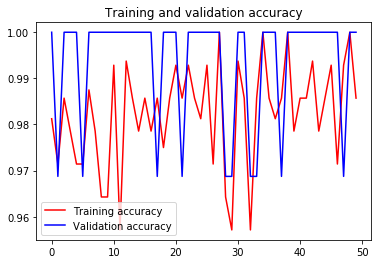

In [127]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TL.png")
plt.show()